# **ASSIGNMENT  4**

**Downloading the data**

In [1]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  7428k      0  0:00:11  0:00:11 --:--:-- 11.7M


**Preparing the data**

In [2]:
import os, pathlib, shutil, random
from tensorflow import keras
b_size = 32
b_dir7= pathlib.Path("/content/aclImdb")
v_dir7 = b_dir7/ "val"
tr_dir7 = b_dir7 / "train"
for category in ("neg", "pos"):
    os.makedirs(v_dir7 / category, exist_ok=True )

    files = os.listdir(tr_dir7 / category)
    random.Random(1496).shuffle(files)
    num_val_samples = 10000
    v_files = files[-num_val_samples:]
    for fname in v_files:
        shutil.move(tr_dir7 / category / fname,
                    v_dir7 / category / fname)

tr_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=b_size
).take(100)  # Restrict training samples to 100

v_ds = keras.utils.text_dataset_from_directory(
    "/content/aclImdb/val", batch_size=b_size
)
te_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=b_size
)
te_only_tr_ds = tr_ds.map(lambda x, y: x)


Found 5000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


Setting up datasets for numeric sequences


A sequence model built on one-hot encoded vector sequences

In [3]:
from tensorflow.keras import layers

max_l = 150   # Cutoff reviews after 150 words
max_t = 10000 # Consider only the top 10,000 word
t_vectorization = layers.TextVectorization(
    max_tokens=max_t,
    output_mode="int",
    output_sequence_length=max_l,
)
t_vectorization.adapt(te_only_tr_ds)

int_tr_ds = tr_ds.map(
    lambda x, y: (t_vectorization(x), y),
    num_parallel_calls=4)
int_v_ds = v_ds.map(
    lambda x, y: (t_vectorization(x), y),
    num_parallel_calls=4)
int_te_ds = te_ds.map(
    lambda x, y: (t_vectorization(x), y),
    num_parallel_calls=4)

In [4]:
import tensorflow as tf  # Model with embedding layer
input = keras.Input(shape=(None,), dtype="int64")
em = layers.Embedding(input_dim=max_t, output_dim=256, mask_zero=True)(input)
x = layers.Bidirectional(layers.LSTM(32))(em)
x = layers.Dropout(0.5)(x)
ou = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(input, ou)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 256) │  2,560,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 64)        │     73,984 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │         65 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

Developing a fundamental sequencing concept initially

In [5]:
cb = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
]
hist= model.fit(int_tr_ds, validation_data=int_v_ds, epochs=15, callbacks=cb)
model = keras.models.load_model("one_hot_bidir_lstm.keras")


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 172ms/step - accuracy: 0.5429 - loss: 0.6893 - val_accuracy: 0.6878 - val_loss: 0.6128
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 169ms/step - accuracy: 0.7026 - loss: 0.5938 - val_accuracy: 0.7762 - val_loss: 0.4916
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 167ms/step - accuracy: 0.8106 - loss: 0.4269 - val_accuracy: 0.7817 - val_loss: 0.4994
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 160ms/step - accuracy: 0.8848 - loss: 0.2973 - val_accuracy: 0.7854 - val_loss: 0.4622
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 164ms/step - accuracy: 0.9154 - loss: 0.2308 - val_accuracy: 0.7674 - val_loss: 0.4850
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 157ms/step - accuracy: 0.9362 - loss: 0.1812 - val_accuracy: 0.7970 - val_loss: 0.4779
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 157ms/step - accuracy: 0.9553 - loss: 0.1280 - val_accuracy: 0.7310 - val_loss: 0.8005
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 159ms/step - accuracy: 0.9739 - loss: 0

In [6]:
test_loss, test_acc = model.evaluate(int_te_ds)
print(f"Test Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

# Evaluate model on the validation dataset
val_loss, val_acc = model.evaluate(int_v_ds)
print(f"Validation Loss: {val_loss:.3f}")
print(f"Validation Accuracy: {val_acc:.3f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.7821 - loss: 0.4684
Test Loss: 0.468
Test Accuracy: 0.780
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.7856 - loss: 0.4662
Validation Loss: 0.462
Validation Accuracy: 0.785


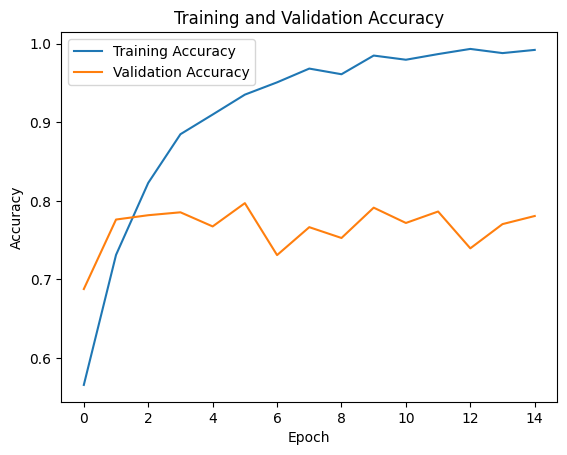

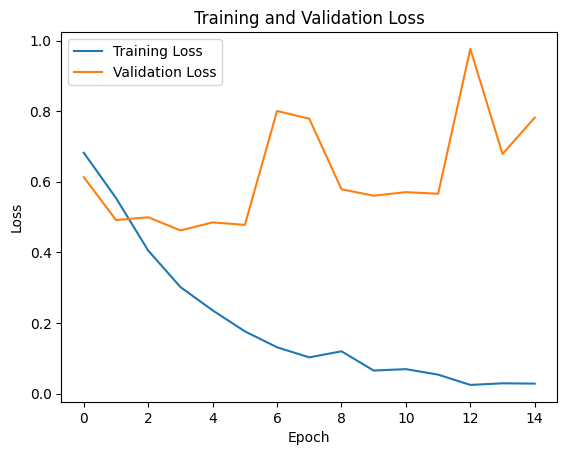

In [7]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Using the Embedded level to acquire embedded words

Putting an Anchoring level into Action

In [8]:
em_layer = layers.Embedding(input_dim=max_t, output_dim=256)

Anchor layer system which was developed form start

In [9]:
in1 = keras.Input(shape=(None,), dtype="int64")
em1 = layers.Embedding(input_dim=max_t, output_dim=256)(in1)
x = layers.Bidirectional(layers.LSTM(32))(em1)
x = layers.Dropout(0.5)(x)
ou1 = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(in1, ou1)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, None, 256)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        73,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
cb1 = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.keras",
                                    save_best_only=True)
]
hist1= model.fit(int_tr_ds, validation_data=int_v_ds, epochs=15, callbacks=cb1)
model = keras.models.load_model("embeddings_bidir_gru.keras")
print(f"Test acc: {model.evaluate(int_te_ds)[1]:.3f}")

Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 0.5062 - loss: 0.6937 - val_accuracy: 0.5480 - val_loss: 0.6801
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 139ms/step - accuracy: 0.6188 - loss: 0.6376 - val_accuracy: 0.7394 - val_loss: 0.5376
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 0.7774 - loss: 0.4963 - val_accuracy: 0.7714 - val_loss: 0.4934
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 0.8331 - loss: 0.3950 - val_accuracy: 0.7831 - val_loss: 0.4743
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 0.8951 - loss: 0.2966 - val_accuracy: 0.7889 - val_loss: 0.4767
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 0.9157 - loss: 0.2527 - val_accuracy: 0.7829 - val_loss: 0.5041
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 139ms/step - accuracy: 0.9290 - loss: 0.1987 - val_accuracy: 0.7864 - val_loss: 0.5193
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 0.9478 - loss: 0

In [11]:
test_loss, test_acc = model.evaluate(int_te_ds)
print(f"Test Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

# Evaluate model on the validation dataset
val_loss, val_acc = model.evaluate(int_v_ds)
print(f"Validation Loss: {val_loss:.3f}")
print(f"Validation Accuracy: {val_acc:.3f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.7779 - loss: 0.4802
Test Loss: 0.480
Test Accuracy: 0.777
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.7808 - loss: 0.4770
Validation Loss: 0.474
Validation Accuracy: 0.783


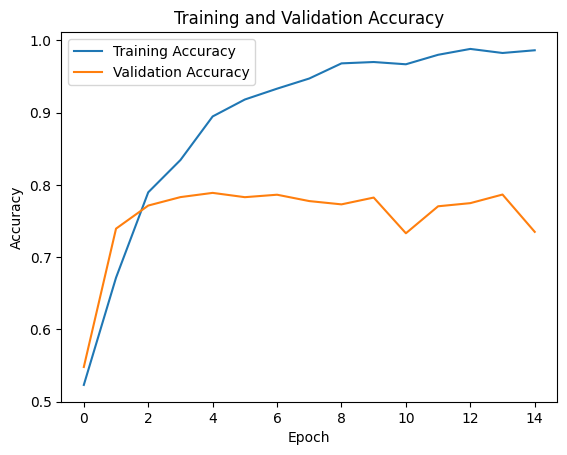

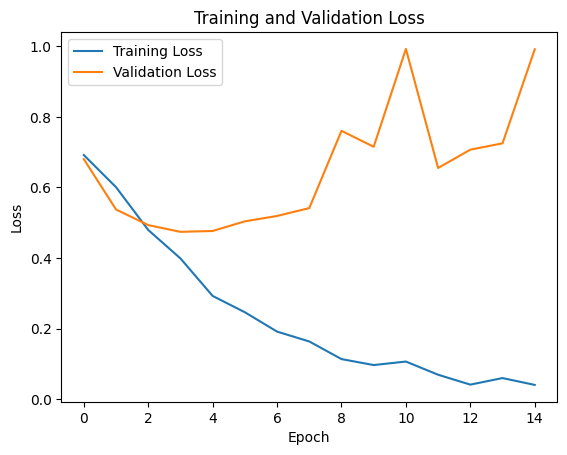

In [12]:
# Plot training and validation accuracy
plt.plot(hist1.history['accuracy'], label='Training Accuracy')
plt.plot(hist1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(hist1.history['loss'], label='Training Loss')
plt.plot(hist1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Recognizing blurring and filling

Applying filtering to an Anchoring level

In [13]:
in2 = keras.Input(shape=(None,), dtype="int64")
em2 = layers.Embedding(
    input_dim=max_t, output_dim=256, mask_zero=True)(in2)
x = layers.Bidirectional(layers.LSTM(32))(em2)
x = layers.Dropout(0.5)(x)
ou2 = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(in2, ou2)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, None, 256) │  2,560,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, None)      │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 64)        │     73,984 │ embedding_3[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
cb2 = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras",
                                    save_best_only=True)
]
hist2=model.fit(int_tr_ds, validation_data=int_v_ds, epochs=15, callbacks=cb2)
model = keras.models.load_model("embeddings_bidir_gru_with_masking.keras")
print(f"Test acc: {model.evaluate(int_te_ds)[1]:.3f}")

Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 172ms/step - accuracy: 0.5315 - loss: 0.6903 - val_accuracy: 0.6987 - val_loss: 0.5925
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 168ms/step - accuracy: 0.7119 - loss: 0.5662 - val_accuracy: 0.7582 - val_loss: 0.4991
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 168ms/step - accuracy: 0.8181 - loss: 0.4212 - val_accuracy: 0.7860 - val_loss: 0.4639
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - accuracy: 0.8842 - loss: 0.3091 - val_accuracy: 0.7982 - val_loss: 0.4390
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - accuracy: 0.9070 - loss: 0.2567 - val_accuracy: 0.7985 - val_loss: 0.4512
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 164ms/step - accuracy: 0.9317 - loss: 0.1907 - val_accuracy: 0.7669 - val_loss: 0.5337
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 167ms/step - accuracy: 0.9622 - loss: 0.1267 - val_accuracy: 0.8082 - val_loss: 0.5264
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - accuracy: 0.9709 - loss: 0

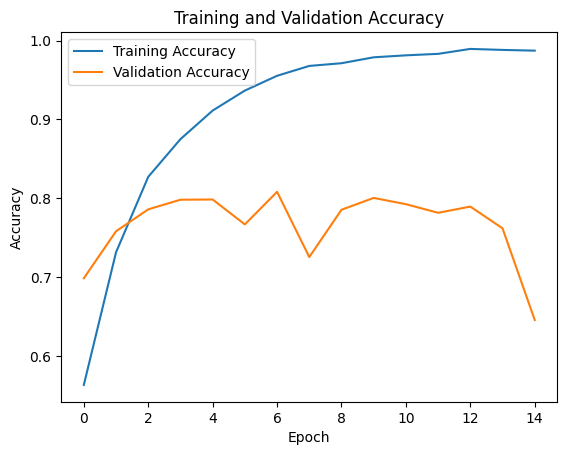

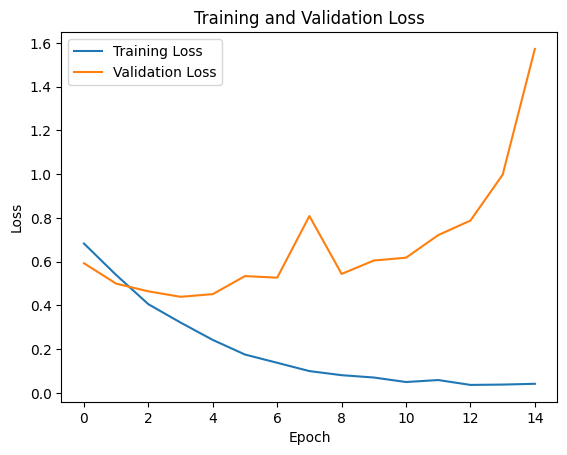

In [15]:
# Plot training and validation accuracy
plt.plot(hist2.history['accuracy'], label='Training Accuracy')
plt.plot(hist2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(hist2.history['loss'], label='Training Loss')
plt.plot(hist2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Preconditioned word embeds are used

In [16]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-11-13 03:51:10--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-11-13 03:51:11--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-11-13 03:51:11--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

# Interpreting the word-embeddings package for One

In [17]:
import numpy as np
path_to_g_file = "glove.6B.100d.txt"

em_index = {}
with open(path_to_g_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        em_index[word] = coefs

print(f"Found {len(em_index)} word vectors.")

Found 400000 word vectors.


Setting up the matrix for the GloVe website embedded words

In [18]:
em_dim = 100

vocab = t_vectorization.get_vocabulary()
wo_index = dict(zip(vocab, range(len(vocab))))

em_matrix = np.zeros((max_t, em_dim))
for word, i in wo_index.items():
    if i < max_t:
        em_vector = em_index.get(word)
    if em_vector is not None:
        em_matrix[i] = em_vector

In [19]:
em_layer = layers.Embedding(
    max_t,
    em_dim,
    embeddings_initializer=keras.initializers.Constant(em_matrix),
    trainable=False,
    mask_zero=True,)

# Architecture with an embedded level which has been trained

In [20]:
in4 = keras.Input(shape=(None,), dtype="int64")
em4 = em_layer(in4)
x = layers.Bidirectional(layers.LSTM(32))(em4)
x = layers.Dropout(0.5)(x)
ou4 = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(in4, ou4)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, None, 100) │  1,000,000 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, None)      │          0 │ input_layer_3[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 64)        │     34,048 │ embedding_4[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,034,113 (3.94 MB)

 Trainable params: 34,113 (133.25 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

In [21]:
cb4 = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
                                    save_best_only=True)
]
hist4=model.fit(int_tr_ds, validation_data=int_v_ds, epochs=15, callbacks=cb4)
model = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test acc: {model.evaluate(int_te_ds)[1]:.3f}")

Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 167ms/step - accuracy: 0.5158 - loss: 0.7062 - val_accuracy: 0.6242 - val_loss: 0.6540
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 164ms/step - accuracy: 0.6482 - loss: 0.6382 - val_accuracy: 0.6955 - val_loss: 0.5864
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 168ms/step - accuracy: 0.6925 - loss: 0.5859 - val_accuracy: 0.6892 - val_loss: 0.5838
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 167ms/step - accuracy: 0.7276 - loss: 0.5457 - val_accuracy: 0.7102 - val_loss: 0.5504
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 163ms/step - accuracy: 0.7555 - loss: 0.5142 - val_accuracy: 0.7347 - val_loss: 0.5315
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - accuracy: 0.7673 - loss: 0.5021 - val_accuracy: 0.7393 - val_loss: 0.5288
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step - accuracy: 0.7717 - loss: 0.4776 - val_accuracy: 0.6921 - val_loss: 0.5682
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 169ms/step - accuracy: 0.7744 - loss: 0

In [22]:
test_loss, test_acc = model.evaluate(int_te_ds)
print(f"Test Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

# Evaluate model on the validation dataset
val_loss, val_acc = model.evaluate(int_v_ds)
print(f"Validation Loss: {val_loss:.3f}")
print(f"Validation Accuracy: {val_acc:.3f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.7859 - loss: 0.4548
Test Loss: 0.456
Test Accuracy: 0.785
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.7822 - loss: 0.4590
Validation Loss: 0.451
Validation Accuracy: 0.787


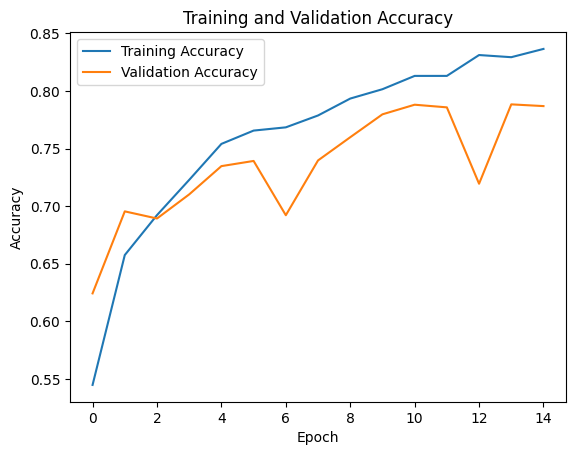

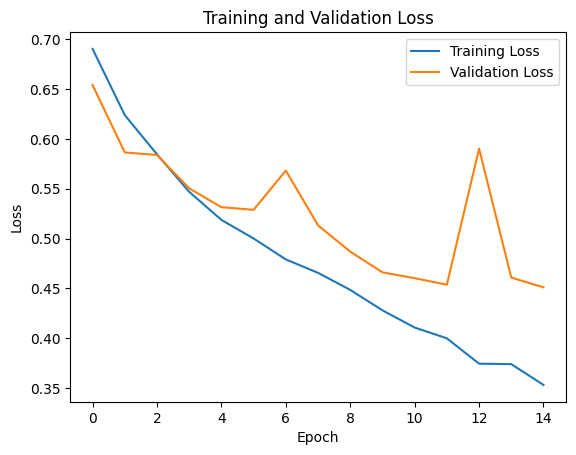

In [23]:
# Plot training and validation accuracy
plt.plot(hist4.history['accuracy'], label='Training Accuracy')
plt.plot(hist4.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(hist4.history['loss'], label='Training Loss')
plt.plot(hist4.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Found 5000 files belonging to 2 classes.
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 118ms/step - accuracy: 0.5224 - loss: 0.6930 - val_accuracy: 0.5573 - val_loss: 0.6868
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - accuracy: 0.6579 - loss: 0.6341 - val_accuracy: 0.7411 - val_loss: 0.5339
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - accuracy: 0.7848 - loss: 0.4739 - val_accuracy: 0.7247 - val_loss: 0.6145
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - accuracy: 0.8512 - loss: 0.3783 - val_accuracy: 0.7819 - val_loss: 0.4701
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - accuracy: 0.8951 - loss: 0.2818 - val_accuracy: 0.7727 - val_loss: 0.4933
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 0.9229 - loss: 0.2252 - val_accuracy: 0.7865 - val_loss: 0.4903
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - accuracy: 0.9247 - loss: 0.1944 - val_accuracy: 0.7922 - val_loss: 0.4877
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12

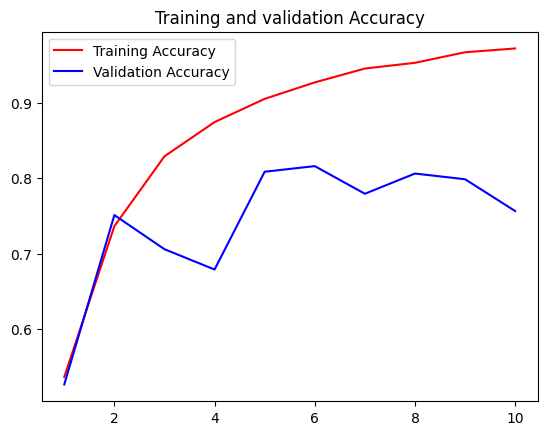

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.5365 - loss: 0.6980 - val_accuracy: 0.6290 - val_loss: 0.6347
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.6540 - loss: 0.6270 - val_accuracy: 0.6802 - val_loss: 0.6019
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.7212 - loss: 0.5602 - val_accuracy: 0.7589 - val_loss: 0.5030
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - accuracy: 0.7510 - loss: 0.5197 - val_accuracy: 0.7467 - val_loss: 0.5078
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.7637 - loss: 0.4978 - val_accuracy: 0.7685 - val_loss: 0.4885
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - accuracy: 0.7838 - loss: 0.4652 - val_accuracy: 0.6956 - val_loss: 0.6054
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - accuracy: 0.7955 - loss: 0.4463 - val_accuracy: 0.7340 - val_loss: 0.5646
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.8020 - loss: 0

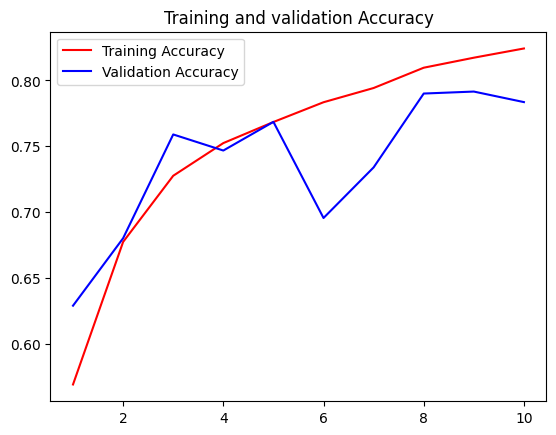

Training samples: 20000
Embedding layer test accuracy: 0.802
Pretrained embeddings test accuracy: 0.784
--------------------------------------------------


In [24]:
train_sample_sizes = [100, 1000, 3000, 5000, 10000, 20000]
for train_size in train_sample_sizes:
    train_ds = keras.utils.text_dataset_from_directory(
        "aclImdb/train", batch_size=b_size
    ).take(train_size)

    int_train_ds = train_ds.map(
        lambda x, y: (t_vectorization(x), y),
        num_parallel_calls=4
    )
    int_val_ds = v_ds.map(
        lambda x, y: (t_vectorization(x), y),
        num_parallel_calls=4
    )
    int_test_ds = te_ds.map(
        lambda x, y: (t_vectorization(x), y),
        num_parallel_calls=4
    )

    # Train and evaluate the model with the embedding layer
    embedding_layer = layers.Embedding(max_t, em_dim)

    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = embedding_layer(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    callbacks = [
        keras.callbacks.ModelCheckpoint("embeddings_model.keras",
                                        save_best_only=True)
    ]
    history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
    model = keras.models.load_model("embeddings_model.keras")


test_loss, test_acc = model.evaluate(int_te_ds)
print(f"Test Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

# Evaluate model on the validation dataset
val_loss, val_acc = model.evaluate(int_v_ds)
print(f"Validation Loss: {val_loss:.3f}")
print(f"Validation Accuracy: {val_acc:.3f}")


embedding_layer_test_acc = model.evaluate(int_test_ds)[1]

loss = history.history["accuracy"]
val_loss = history.history["val_accuracy"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "r", label="Training Accuracy")
plt.plot(epochs, val_loss, "b", label="Validation Accuracy")
plt.title("Training and validation Accuracy")
plt.legend()
plt.show()

# Train and evaluate the model with the pretrained word embeddings
embedding_layer = layers.Embedding(
        max_t,
        em_dim,
        embeddings_initializer=keras.initializers.Constant(em_matrix),
        trainable=False,
        mask_zero=True,
    )

inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

callbacks = [
        keras.callbacks.ModelCheckpoint("pretrained_embeddings_model.keras",
                                        save_best_only=True)
    ]
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("pretrained_embeddings_model.keras")
pretrained_embeddings_test_acc = model.evaluate(int_test_ds)[1]

loss = history.history["accuracy"]
val_loss = history.history["val_accuracy"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "r", label="Training Accuracy")
plt.plot(epochs, val_loss, "b", label="Validation Accuracy")
plt.title("Training and validation Accuracy")
plt.legend()
plt.show()

# Compare the performance and store the results
print(f"Training samples: {train_size}")
print(f"Embedding layer test accuracy: {embedding_layer_test_acc:.3f}")
print(f"Pretrained embeddings test accuracy: {pretrained_embeddings_test_acc:.3f}")
print("-" * 50)


Training with 100 samples...
Found 5000 files belonging to 2 classes.
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 0.5134 - loss: 0.6911 - val_accuracy: 0.6637 - val_loss: 0.6177
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 0.7001 - loss: 0.5970 - val_accuracy: 0.7290 - val_loss: 0.5568
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - accuracy: 0.7863 - loss: 0.4776 - val_accuracy: 0.7735 - val_loss: 0.4839
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 0.8519 - loss: 0.3695 - val_accuracy: 0.7671 - val_loss: 0.4835
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 0.9043 - loss: 0.2726 - val_accuracy: 0.7667 - val_loss: 0.5114
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 0.9250 - loss: 0.2088 - val_accuracy: 0.7548 - val_loss: 0.5202
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - accuracy: 0.9465 - loss: 0.1724 - val_accuracy: 0.7960 - val_loss: 0.4944
Epoch 8/10
10

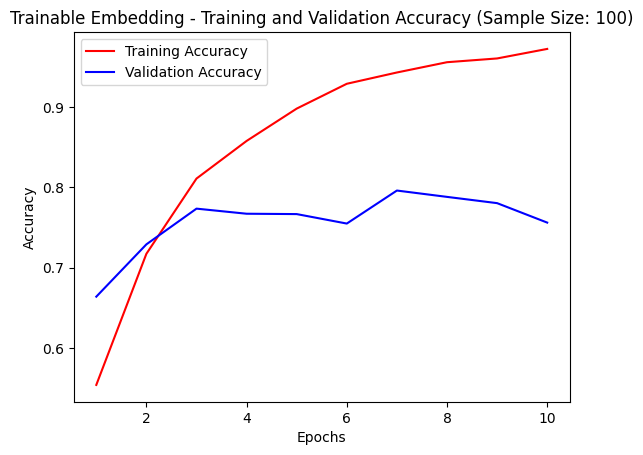

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 174ms/step - accuracy: 0.5243 - loss: 0.6922 - val_accuracy: 0.6326 - val_loss: 0.6515
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 167ms/step - accuracy: 0.6484 - loss: 0.6416 - val_accuracy: 0.6860 - val_loss: 0.6050
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.6833 - loss: 0.5952 - val_accuracy: 0.6188 - val_loss: 0.6633
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 167ms/step - accuracy: 0.7072 - loss: 0.5727 - val_accuracy: 0.7197 - val_loss: 0.5469
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - accuracy: 0.7395 - loss: 0.5314 - val_accuracy: 0.7436 - val_loss: 0.5162
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 167ms/step - accuracy: 0.7500 - loss: 0.5078 - val_accuracy: 0.7564 - val_loss: 0.5088
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.7597 - loss: 0.4984 - val_accuracy: 0.7592 - val_loss: 0.5106
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.7766 - loss: 0

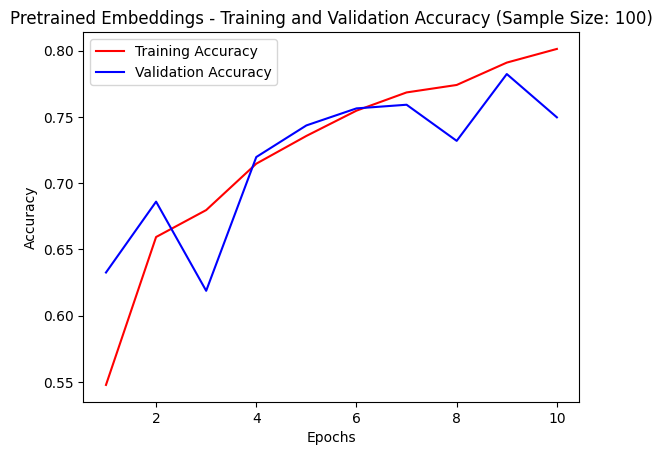

===== Summary for train_size = 100 =====
Embedding layer test accuracy: 0.761
Pretrained embeddings test accuracy: 0.780
--------------------------------------------------
Training with 1000 samples...
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step - accuracy: 0.5203 - loss: 0.6895 - val_accuracy: 0.6448 - val_loss: 0.6444
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 96ms/step - accuracy: 0.7288 - loss: 0.5594 - val_accuracy: 0.7635 - val_loss: 0.5023
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 96ms/step - accuracy: 0.8313 - loss: 0.4091 - val_accuracy: 0.7333 - val_loss: 0.7728
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 96ms/step - accuracy: 0.8713 - loss: 0.3206 - val_accuracy: 0.8094 - val_loss: 0.4797
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - accuracy: 0.9101 - loss: 0.2531 - val_accuracy: 0.7964 - val_loss: 0.4544
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - accuracy: 0.9264 - loss: 0.2073 - val_accuracy: 0.7

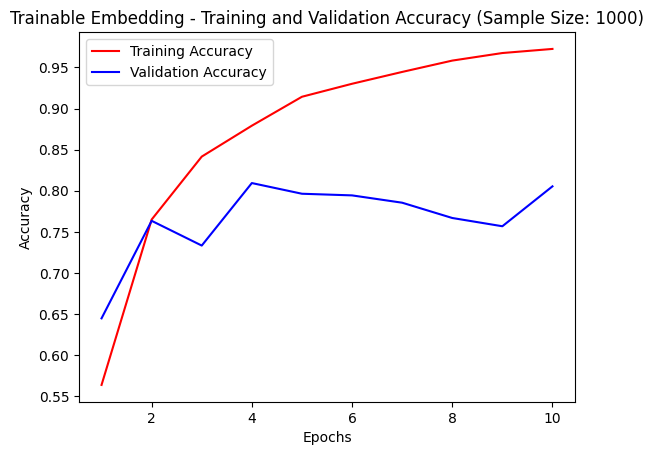

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.5491 - loss: 0.6920 - val_accuracy: 0.6761 - val_loss: 0.6122
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - accuracy: 0.6481 - loss: 0.6343 - val_accuracy: 0.6658 - val_loss: 0.6224
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.7178 - loss: 0.5697 - val_accuracy: 0.6618 - val_loss: 0.6229
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - accuracy: 0.7334 - loss: 0.5319 - val_accuracy: 0.6715 - val_loss: 0.6324
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - accuracy: 0.7591 - loss: 0.4940 - val_accuracy: 0.7444 - val_loss: 0.5454
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 132ms/step - accuracy: 0.7849 - loss: 0.4689 - val_accuracy: 0.7649 - val_loss: 0.4882
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.7902 - loss: 0.4551 - val_accuracy: 0.7769 - val_loss: 0.4687
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - accuracy: 0.8004 - loss: 0

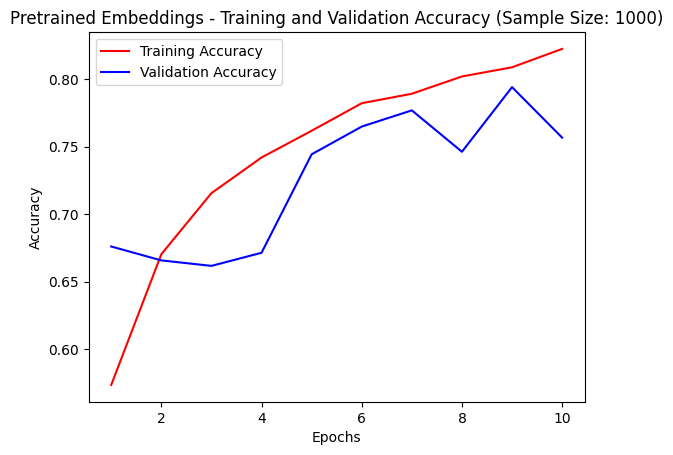

===== Summary for train_size = 1000 =====
Embedding layer test accuracy: 0.787
Pretrained embeddings test accuracy: 0.772
--------------------------------------------------
Training with 3000 samples...
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step - accuracy: 0.5241 - loss: 0.6903 - val_accuracy: 0.6459 - val_loss: 0.6359
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 102ms/step - accuracy: 0.7100 - loss: 0.5803 - val_accuracy: 0.7653 - val_loss: 0.5048
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - accuracy: 0.8133 - loss: 0.4409 - val_accuracy: 0.7962 - val_loss: 0.4488
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 95ms/step - accuracy: 0.8667 - loss: 0.3398 - val_accuracy: 0.7445 - val_loss: 0.5356
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 95ms/step - accuracy: 0.9006 - loss: 0.2796 - val_accuracy: 0.7912 - val_loss: 0.4715
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - accuracy: 0.9140 - loss: 0.2456 - val_accuracy: 

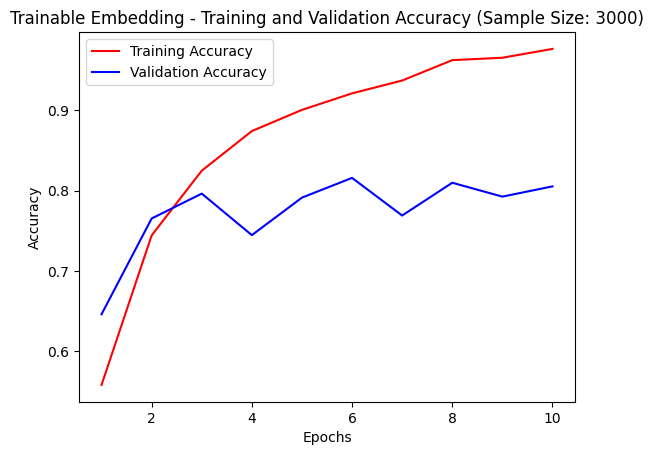

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.5370 - loss: 0.6964 - val_accuracy: 0.5950 - val_loss: 0.6604
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - accuracy: 0.6624 - loss: 0.6202 - val_accuracy: 0.7369 - val_loss: 0.5386
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - accuracy: 0.7264 - loss: 0.5548 - val_accuracy: 0.7082 - val_loss: 0.5580
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - accuracy: 0.7389 - loss: 0.5296 - val_accuracy: 0.7706 - val_loss: 0.4833
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.7534 - loss: 0.5066 - val_accuracy: 0.7018 - val_loss: 0.5553
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - accuracy: 0.7675 - loss: 0.4873 - val_accuracy: 0.7352 - val_loss: 0.5548
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - accuracy: 0.7851 - loss: 0.4585 - val_accuracy: 0.7811 - val_loss: 0.4580
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - accuracy: 0.7959 - loss: 0

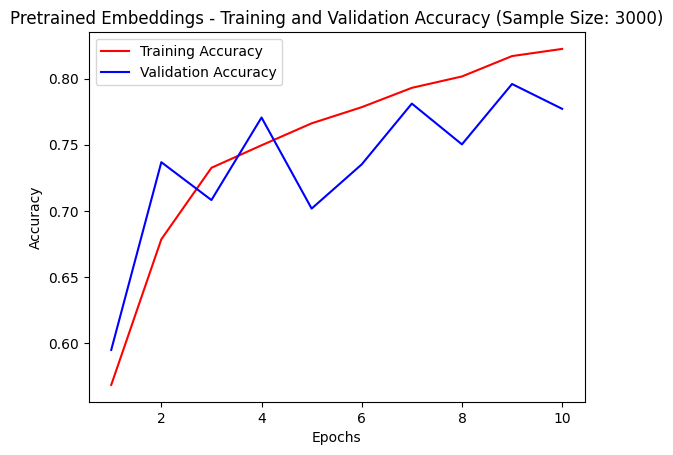

===== Summary for train_size = 3000 =====
Embedding layer test accuracy: 0.788
Pretrained embeddings test accuracy: 0.795
--------------------------------------------------
Training with 5000 samples...
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.5136 - loss: 0.6899 - val_accuracy: 0.6905 - val_loss: 0.5947
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - accuracy: 0.7417 - loss: 0.5421 - val_accuracy: 0.7747 - val_loss: 0.4914
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - accuracy: 0.8387 - loss: 0.4041 - val_accuracy: 0.7060 - val_loss: 0.8222
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 95ms/step - accuracy: 0.8659 - loss: 0.3518 - val_accuracy: 0.7993 - val_loss: 0.4436
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - accuracy: 0.9014 - loss: 0.2645 - val_accuracy: 0.8187 - val_loss: 0.4669
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 95ms/step - accuracy: 0.9241 - loss: 0.2277 - val_accuracy: 0.

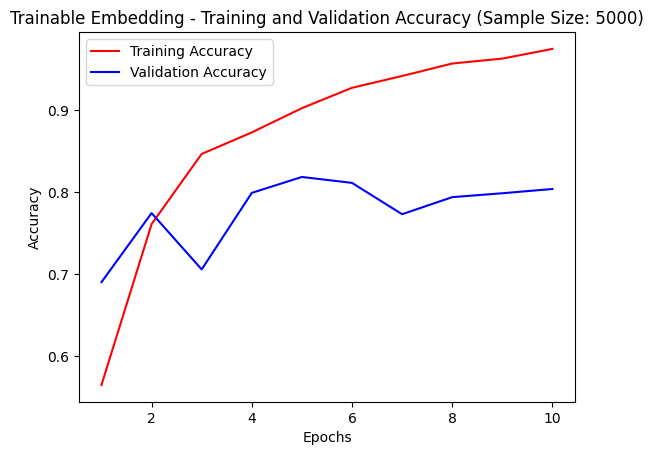

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - accuracy: 0.5493 - loss: 0.6934 - val_accuracy: 0.6378 - val_loss: 0.6467
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step - accuracy: 0.6775 - loss: 0.6046 - val_accuracy: 0.7272 - val_loss: 0.5437
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step - accuracy: 0.7290 - loss: 0.5496 - val_accuracy: 0.7401 - val_loss: 0.5305
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.7482 - loss: 0.5192 - val_accuracy: 0.7586 - val_loss: 0.5040
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.7665 - loss: 0.4875 - val_accuracy: 0.7729 - val_loss: 0.4845
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step - accuracy: 0.7891 - loss: 0.4700 - val_accuracy: 0.7739 - val_loss: 0.4797
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - accuracy: 0.7961 - loss: 0.4464 - val_accuracy: 0.7420 - val_loss: 0.5152
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.7994 - loss: 0

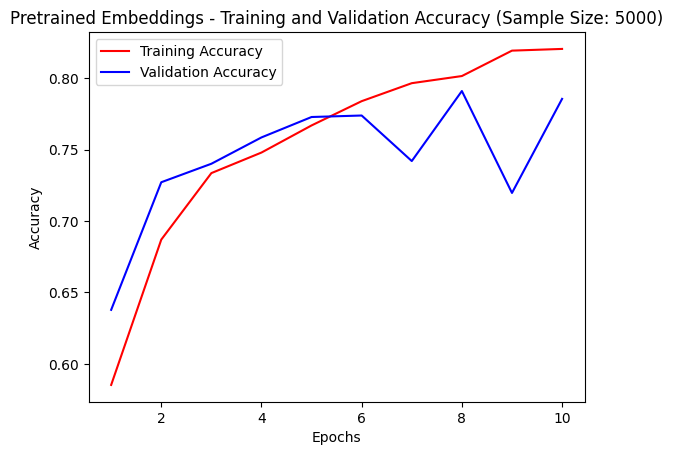

===== Summary for train_size = 5000 =====
Embedding layer test accuracy: 0.783
Pretrained embeddings test accuracy: 0.786
--------------------------------------------------
Training with 10000 samples...
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.5159 - loss: 0.6898 - val_accuracy: 0.6209 - val_loss: 0.6575
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - accuracy: 0.7285 - loss: 0.5605 - val_accuracy: 0.7425 - val_loss: 0.5341
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - accuracy: 0.8101 - loss: 0.4462 - val_accuracy: 0.8092 - val_loss: 0.4314
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - accuracy: 0.8710 - loss: 0.3354 - val_accuracy: 0.7739 - val_loss: 0.4785
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - accuracy: 0.8969 - loss: 0.2775 - val_accuracy: 0.7167 - val_loss: 0.8594
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - accuracy: 0.9216 - loss: 0.2267 - val_accuracy: 0

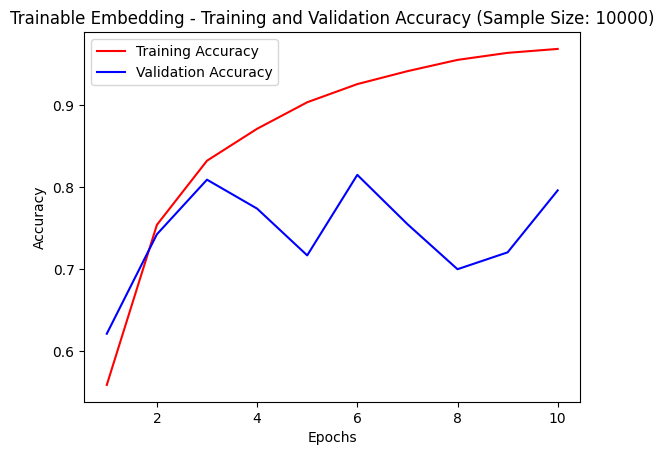

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.5476 - loss: 0.6890 - val_accuracy: 0.5634 - val_loss: 0.7392
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.6766 - loss: 0.6084 - val_accuracy: 0.7080 - val_loss: 0.5855
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.7197 - loss: 0.5619 - val_accuracy: 0.7524 - val_loss: 0.5148
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.7392 - loss: 0.5249 - val_accuracy: 0.7001 - val_loss: 0.5653
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - accuracy: 0.7615 - loss: 0.4971 - val_accuracy: 0.7789 - val_loss: 0.4731
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - accuracy: 0.7895 - loss: 0.4619 - val_accuracy: 0.7829 - val_loss: 0.4671
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.7920 - loss: 0.4448 - val_accuracy: 0.7900 - val_loss: 0.4481
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - accuracy: 0.8082 - loss: 0

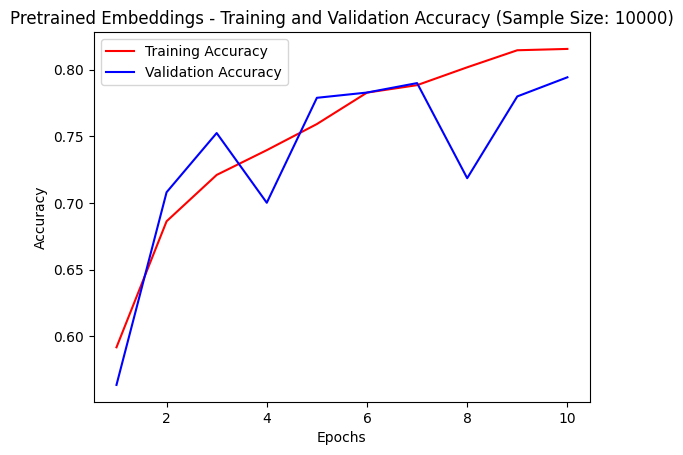

===== Summary for train_size = 10000 =====
Embedding layer test accuracy: 0.802
Pretrained embeddings test accuracy: 0.790
--------------------------------------------------
Training with 20000 samples...
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.5164 - loss: 0.6925 - val_accuracy: 0.5397 - val_loss: 0.7525
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 98ms/step - accuracy: 0.6898 - loss: 0.6084 - val_accuracy: 0.7754 - val_loss: 0.4943
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 98ms/step - accuracy: 0.8067 - loss: 0.4563 - val_accuracy: 0.7901 - val_loss: 0.4783
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 96ms/step - accuracy: 0.8494 - loss: 0.3633 - val_accuracy: 0.7804 - val_loss: 0.4782
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 96ms/step - accuracy: 0.8916 - loss: 0.2963 - val_accuracy: 0.8034 - val_loss: 0.4604
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 96ms/step - accuracy: 0.9254 - loss: 0.2180 - val_accuracy: 

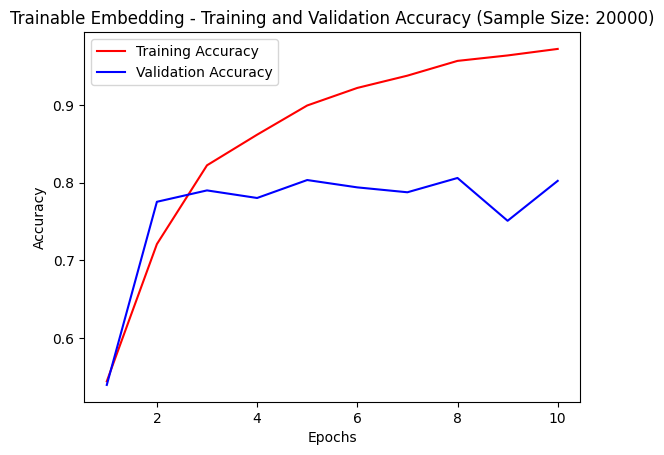

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - accuracy: 0.5200 - loss: 0.7051 - val_accuracy: 0.6417 - val_loss: 0.6440
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.6593 - loss: 0.6298 - val_accuracy: 0.7300 - val_loss: 0.5535
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.7084 - loss: 0.5780 - val_accuracy: 0.7407 - val_loss: 0.5380
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 123ms/step - accuracy: 0.7294 - loss: 0.5430 - val_accuracy: 0.6037 - val_loss: 0.7427
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - accuracy: 0.7487 - loss: 0.5190 - val_accuracy: 0.7211 - val_loss: 0.5477
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.7683 - loss: 0.4993 - val_accuracy: 0.7441 - val_loss: 0.5153
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.7901 - loss: 0.4578 - val_accuracy: 0.7752 - val_loss: 0.4751
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.7898 - loss: 0

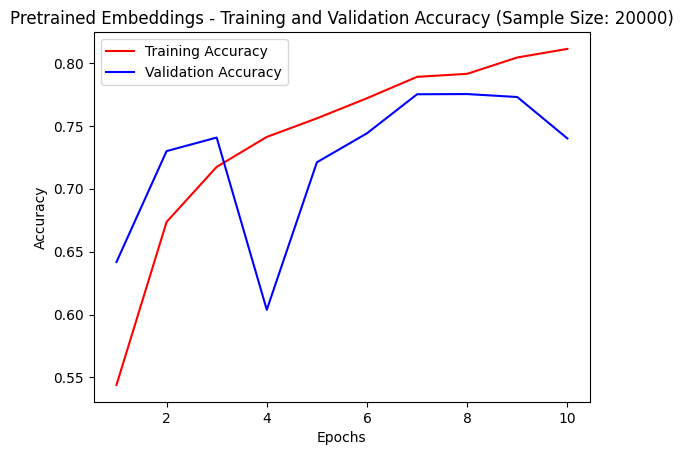

===== Summary for train_size = 20000 =====
Embedding layer test accuracy: 0.790
Pretrained embeddings test accuracy: 0.772
--------------------------------------------------

====== OVERALL SUMMARY ======
Training samples: 100
Embedding layer test accuracy: 0.761
Pretrained embeddings test accuracy: 0.780
--------------------------------------------------
Training samples: 1000
Embedding layer test accuracy: 0.787
Pretrained embeddings test accuracy: 0.772
--------------------------------------------------
Training samples: 3000
Embedding layer test accuracy: 0.788
Pretrained embeddings test accuracy: 0.795
--------------------------------------------------
Training samples: 5000
Embedding layer test accuracy: 0.783
Pretrained embeddings test accuracy: 0.786
--------------------------------------------------
Training samples: 10000
Embedding layer test accuracy: 0.802
Pretrained embeddings test accuracy: 0.790
--------------------------------------------------
Training samples: 20000
E

In [26]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Initialize the results list to store metrics
results = []

train_sample_sizes = [100, 1000, 3000, 5000, 10000, 20000]

for train_size in train_sample_sizes:
    print(f"Training with {train_size} samples...")

    # Load training dataset with the specific sample size

    train_ds = keras.utils.text_dataset_from_directory(
        "aclImdb/train", batch_size=b_size
    ).take(train_size)

    # Map datasets for vectorization
    int_train_ds = train_ds.map(
        lambda x, y: (t_vectorization(x), y),
        num_parallel_calls=4
    )
    int_val_ds = v_ds.map(
        lambda x, y: (t_vectorization(x), y),
        num_parallel_calls=4
    )
    int_test_ds = te_ds.map(
        lambda x, y: (t_vectorization(x), y),
        num_parallel_calls=4
    )


    # 1) Train and evaluate model with trainable embedding layer

    embedding_layer = layers.Embedding(max_t, em_dim)

    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = embedding_layer(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer="rmsprop",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    callbacks = [
        keras.callbacks.ModelCheckpoint("embeddings_model.keras", save_best_only=True)
    ]

    history = model.fit(
        int_train_ds,
        validation_data=int_val_ds,
        epochs=10,
        callbacks=callbacks
    )

    model = keras.models.load_model("embeddings_model.keras")

    # Evaluate on the test set
    test_loss, test_acc = model.evaluate(int_test_ds)
    print(f"[Trainable Embedding] Test Loss: {test_loss:.3f}")
    print(f"[Trainable Embedding] Test Accuracy: {test_acc:.3f}")

    # Evaluate on the validation set
    val_loss, val_acc = model.evaluate(int_val_ds)
    print(f"[Trainable Embedding] Validation Loss: {val_loss:.3f}")
    print(f"[Trainable Embedding] Validation Accuracy: {val_acc:.3f}")

    # Store results for embedding layer
    embedding_layer_test_acc = test_acc
    embedding_layer_val_acc = val_acc
    embedding_layer_train_acc = history.history['accuracy'][-1]
    embedding_layer_val_loss = history.history['val_loss'][-1]

    # Plot the training and validation accuracy (trainable embedding)
    acc = history.history["accuracy"]
    val_acc_hist = history.history["val_accuracy"]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, "r", label="Training Accuracy")
    plt.plot(epochs, val_acc_hist, "b", label="Validation Accuracy")
    plt.title(f"Trainable Embedding - Training and Validation Accuracy (Sample Size: {train_size})")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


    # 2) Train and evaluate model with pretrained embeddings

    embedding_layer_pretrained = layers.Embedding(
        max_t,
        em_dim,
        embeddings_initializer=keras.initializers.Constant(em_matrix),
        trainable=False,
        mask_zero=True,
    )

    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = embedding_layer_pretrained(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer="rmsprop",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    callbacks = [
        keras.callbacks.ModelCheckpoint("pretrained_embeddings_model.keras", save_best_only=True)
    ]

    history = model.fit(
        int_train_ds,
        validation_data=int_val_ds,
        epochs=10,
        callbacks=callbacks
    )

    model = keras.models.load_model("pretrained_embeddings_model.keras")

    # Evaluate on the test set
    pretrained_test_loss, pretrained_test_acc = model.evaluate(int_test_ds)
    print(f"[Pretrained Embedding] Test Loss: {pretrained_test_loss:.3f}")
    print(f"[Pretrained Embedding] Test Accuracy: {pretrained_test_acc:.3f}")

    # Plot the training and validation accuracy for pretrained embeddings
    acc = history.history["accuracy"]
    val_acc_hist = history.history["val_accuracy"]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, "r", label="Training Accuracy")
    plt.plot(epochs, val_acc_hist, "b", label="Validation Accuracy")
    plt.title(f"Pretrained Embeddings - Training and Validation Accuracy (Sample Size: {train_size})")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


    # Store all results for this train_size in ONE dict

    result_entry = {
        'train_size': train_size,
        'embedding_layer_test_acc': embedding_layer_test_acc,
        'embedding_layer_val_acc': embedding_layer_val_acc,
        'embedding_layer_train_acc': embedding_layer_train_acc,
        'embedding_layer_val_loss': embedding_layer_val_loss,
        'pretrained_embeddings_test_acc': pretrained_test_acc
    }
    results.append(result_entry)

    print(f"===== Summary for train_size = {train_size} =====")
    print(f"Embedding layer test accuracy: {embedding_layer_test_acc:.3f}")
    print(f"Pretrained embeddings test accuracy: {pretrained_test_acc:.3f}")
    print("-" * 50)


# After all iterations, print the summary of results

print("\n====== OVERALL SUMMARY ======")
for result in results:
    print(f"Training samples: {result['train_size']}")
    print(f"Embedding layer test accuracy: {result['embedding_layer_test_acc']:.3f}")
    print(f"Pretrained embeddings test accuracy: {result['pretrained_embeddings_test_acc']:.3f}")
    print("-" * 50)
